In [1]:
import numpy as np
from numpy import pi
from numpy.fft import rfftfreq, rfft, irfft
from numpy.random import default_rng

from scipy import odr
from scipy.stats import cumfreq, chi2, norm, probplot

from matplotlib import pyplot as plt
from matplotlib.figure import figaspect

from thztools.thztools import thzgen, noiseamp

In [2]:
n = 256     # Number of samples
ts = 0.05   # Sampling time [ps]
t0 = 2.5    # Peak pulse time [ps]
fs = 1 / ts # Sampling frequency [THz]

sigma_alpha = 1e-4  # Additive noise amplitude [signal units]
sigma_beta = 1e-2   # Multiplicative noise amplitude [dimensionless]
sigma_tau = 1e-3    # Time base noise amplitude [ps]
sigma_parms = np.array([sigma_alpha, sigma_beta, sigma_tau])

seed = 0    # RNG seed
rng = default_rng(seed)

In [3]:
n_sim = 250

mu, t = thzgen(n, ts, t0)
sigma = noiseamp(sigma_parms, mu, ts)

x = mu + sigma * rng.standard_normal((n_sim, n))
y = mu + sigma * rng.standard_normal((n_sim, n))

Note that the FFT routines assume the $+i\omega t$ convention.

In [4]:
def tf_model(_p, _w):
    return _p[0] * np.exp(-1j * _w * _p[1])

f = rfftfreq(n, ts)
def td_model(_p, _x):
    _y = irfft(rfft(_x) * tf_model(_p, 2 * pi * f), n=n)
    return _y

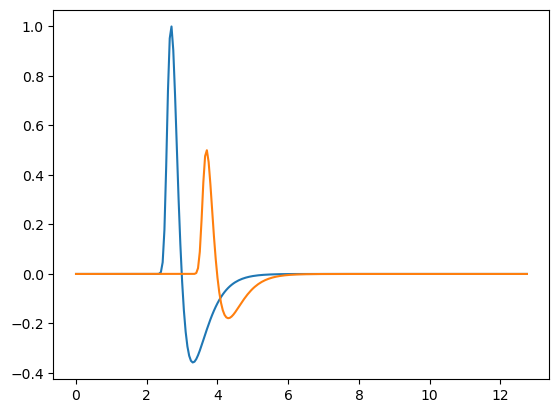

In [5]:
plt.plot(t, mu)
plt.plot(t, td_model((0.5, 1), mu))
plt.show()

In [6]:
%%time

p_odr = np.empty((2, n_sim))
resnorm_odr = np.empty((n_sim,))
epsilon_odr = np.empty((n, n_sim))
delta_odr = np.empty((n, n_sim))
sigma_odr = np.empty((2, n_sim))

model = odr.Model(td_model)

for i in range(n_sim):
    data = odr.RealData(x[i, :], y=y[i, :], sx=sigma, sy=sigma)
    fit = odr.ODR(data, model, beta0=(1, 0))
    result = fit.run()
    p_odr[:, i] = result.beta
    epsilon_odr[:, i] = result.eps
    delta_odr[:, i] = result.delta
    resnorm_odr[i] = result.sum_square
    sigma_odr[:, i] = result.sd_beta
    if not result.info < 4:
        print(f"Fit did not converge at i = {i}")

cf_odr = cumfreq(resnorm_odr, 1000, defaultreallimits=(0, 1000))
gof_odr = cf_odr.lowerlimit + np.linspace(0, cf_odr.binsize * cf_odr.cumcount.size,
                          cf_odr.cumcount.size)
ecdf_odr = cf_odr.cumcount / n_sim

CPU times: user 1.02 s, sys: 135 ms, total: 1.15 s
Wall time: 721 ms


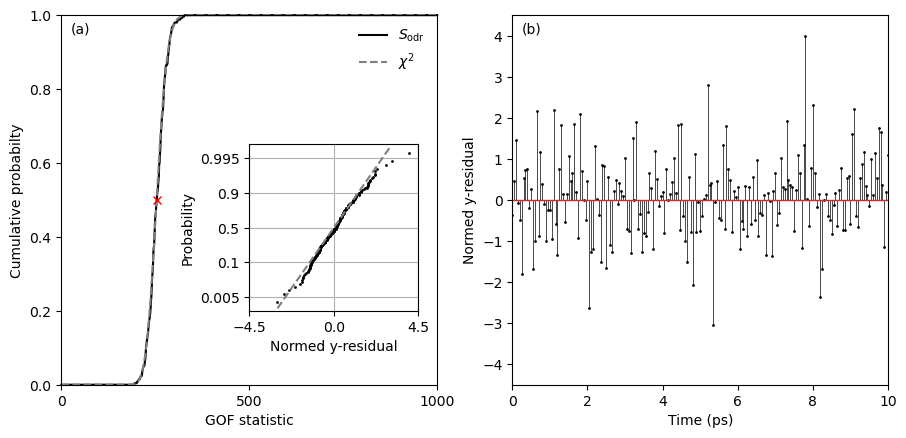

In [7]:
# Find the index of the median value
i_show = np.argsort(resnorm_odr)[len(resnorm_odr) // 2]
norm_res_eps = np.sqrt(512 / 254) * epsilon_odr[:, i_show] / sigma
osm, osr = probplot(norm_res_eps, fit=False)

w, h = figaspect(0.45)
_, axs = plt.subplots(1, 2, figsize=(w, h))

# Panel (a)
axs[0].plot(gof_odr, ecdf_odr, 'k-', label=r'$S_\mathrm{odr}$', clip_on=False)
axs[0].plot(gof_odr, chi2.cdf(gof_odr, n - 2), '--', c='gray', label=r'$\chi^2$', clip_on=False)
axs[0].plot(np.median(resnorm_odr), 0.5, 'rx')

axs[0].legend(loc='upper right', frameon=False)
axs[0].text(0.025, 0.95, '(a)', transform=axs[0].transAxes)

axs[0].set_xlim(0, 1000)
axs[0].set_ylim(0, 1)

axs[0].set_xticks([0, 500, 1000])
axs[0].set_yticks(np.linspace(0, 1, 6, endpoint=True))

axs[0].set_xlabel('GOF statistic')
axs[0].set_ylabel('Cumulative probabilty')

# Inset to (a)
ins = axs[0].inset_axes([0.5, 0.2, 0.45, 0.45])
ins.plot(osr, osm, 'k.', ms=2)
ins.plot([-3, 3], [-3, 3], '--', c='gray')
ins.grid()

ins.set_xlim(-3, 3)
ins.set_ylim(norm.ppf([0.001, 0.999]))

ins.set_xticks([-4.5, 0, 4.5])
ins.set_yticks(norm.ppf([ 0.005, 0.1, 0.5, 0.9, 0.995]))

ins.set_yticklabels(['0.005', '0.1', '0.5', '0.9', '0.995'])

ins.set_xlabel('Normed y-residual')
ins.set_ylabel('Probability')

# Panel (b)
markerline, stemlines, baseline = axs[1].stem(t, norm_res_eps,
                                              linefmt = 'k-',
                                              markerfmt='.')
markerline.set_markersize(2)
stemlines.set_linewidth(0.5)
baseline.set_linewidth(1)

axs[1].text(0.025, 0.95, '(b)', transform=axs[1].transAxes)

axs[1].set_xlim(0, 10)
axs[1].set_ylim(-4.5, 4.5)

axs[1].set_xlabel('Time (ps)')
axs[1].set_ylabel('Normed y-residual')

plt.show()